In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sns
import datetime
import plotly.graph_objects as go
import plotly.express as px
from os.path import exists
import matplotlib.colors as mcolors



In [2]:
def gini(list_of_values):
    n = len(list_of_values)
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area * (n-1)/n


def convert_blocktime(blocktime):
    if blocktime is None:
        return None
    else:
        timestr = blocktime.replace('T',' ').replace('Z','')
        return datetime.datetime.strptime(timestr[:-6], "%Y-%m-%d %H:%M:%S")

In [3]:
def get_user_grp(df, month_list):
    #for month over month behaviour of users (sankey chart)
    #1) new past 30d
    #2) repeat 30d
    #3) repeat 90d
    #4) active non repeat 90d
    #5) non active >180d
    #6) non active >365d
    # look what they did past month, e.g. repeat 30d means they traded past 30days, mustnt mean they also trade this month
    df['user_grp']=''
    for num_month in range(0,len(month_list)):
    
        #1 new: started trading past 30days
        if num_month==0:
            df.loc[(df.month_date==month_list[num_month]) & (df.day_first<=30),'user_grp']='new'
        
        if num_month>0:
            #months like february mess up above logic, so need to force that trader wasn't around last month
            df.loc[(df.month_date==month_list[num_month]) & (df.day_first<=30)
            & (~df.trader.isin(df[(df.month_date==month_list[num_month-1]) ].trader.unique())),'user_grp']='new'

            #1 repeat 30d: traded 30days
            df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.trader.isin(df[(df.month_date==month_list[num_month-1])&
                (df.swaps_30d>0)].trader.unique())),'user_grp'] = 'repeat_30d'
            
            #2 repeat 90d: didn't traded last 30days, but last 90days
            df.loc[(df.month_date==month_list[num_month]) & 
                (df.user_grp=='') & 
            (df.trader.isin(df[(df.month_date==month_list[num_month-1])&
                (df.swaps_90d>0)].trader.unique())),'user_grp'] = 'repeat_90d'

            #3 repeat 90d: didn't traded last 90days, but last 180days
            df.loc[(df.month_date==month_list[num_month]) & 
                (df.user_grp=='') &
                (df.trader.isin(df[(df.month_date==month_list[num_month-1])&
                (df.swaps_180d>0)].trader.unique())),'user_grp'] = 'repeat_180d'
        else:
            #adjust logic when we cant look at the prior month - then just take current month, same logic
            df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.trader.isin(df[(df.month_date==month_list[num_month])&
                (df.swaps_30d>0)].trader.unique())),'user_grp'] = 'repeat_30d'    
        
            df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.trader.isin(df[(df.month_date==month_list[num_month])&
                (df.swaps_90d>0)].trader.unique())),'user_grp'] = 'repeat_90d'    
            
            df.loc[(df.month_date==month_list[num_month]) & 
                (df.user_grp=='') &
                (df.trader.isin(df[(df.month_date==month_list[num_month])&
                (df.swaps_180d>0)].trader.unique())),'user_grp'] = 'repeat_180d'


        #no group yet, but last trade <1y -> not active >180days
        df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.day_last<=365)
            ,'user_grp'] = 'not active >6m'

        #no group yet, but last trade >1y -> not active >1 year
        df.loc[(df.month_date==month_list[num_month]) & 
            (df.user_grp=='') &
            (df.day_last>365)
            ,'user_grp'] = 'not active >1y'





In [4]:
def add_nodes(df, lst_months_labels):
    df['node']=-1
    df['node_label']=''
    lst_months=df.month_date.unique()
    lst_user_grp=df.user_grp.unique()
    lst_node_labels=[]
    lst_nodes = []
    lst_colors=[]

    cnt = 0

    for cnt_month in range(0,len(lst_months)):
        for user_grp_name in lst_user_grp:
            df.loc[(df.month_date==lst_months[cnt_month]) & (df.user_grp==user_grp_name),'node']=cnt
            df.loc[(df.month_date==lst_months[cnt_month]) & (df.user_grp==user_grp_name),'node_label']=lst_months_labels[cnt_month] + '/' +  user_grp_name
            lst_node_labels.append(lst_months_labels[cnt_month] + '/' +  user_grp_name)
            lst_nodes.append(cnt)
            if user_grp_name=='new':
                lst_colors.append('yellow')
            elif user_grp_name=='repeat_30d':
                lst_colors.append('lightgreen')
            elif user_grp_name=='repeat_90d':
                lst_colors.append('darkgreen')
            elif user_grp_name=='repeat_180d':
                lst_colors.append('steelblue')
            elif user_grp_name=='not active >6m':
                lst_colors.append('mediumpurple')
            elif user_grp_name=='not active >1y':
                lst_colors.append('indigo')
            cnt+=1

    return {'lst_nodes':lst_nodes,'lst_node_labels':lst_node_labels, 'lst_colors':lst_colors}
            

In [5]:
def df_sankey_mapping(df):
    
        
    lst_months=df.month_date.unique()
    dct_sankey = {
    'source':[],
    'target':[],
    'num_wallets':[],
    'volume_30d':[],
    # 'share_vol':[],
    'swaps_30d':[]
    # 'share_wallets':[],
    # 'volume_30d':[],
    # 'share_volume_30d':[],
    # 'swaps_30d':[],
    # 'share_swaps_30d':[]
    }

    for num_month in range(1,len(lst_months)):
        for user_grp_name_source in lst_user_grp:
                for user_grp_name_target in lst_user_grp:
                    tmp= df[(df.trader.isin(df[(df.month_date==lst_months[num_month-1]) &
                                                                                (df.user_grp==user_grp_name_source)].trader.unique())) 
                                    & (df.month_date==lst_months[num_month])
                                    & (df.user_grp==user_grp_name_target)]

                    if tmp.trader.nunique()>0:
                        dct_sankey['source'].append(df[(df.month_date==lst_months[num_month-1]) &
                                                                                    (df.user_grp==user_grp_name_source)].node.iloc[0])
                        dct_sankey['target'].append(df[(df.month_date==lst_months[num_month]) &
                                                                                    (df.user_grp==user_grp_name_target)].node.iloc[0])
                        dct_sankey['num_wallets'].append(tmp.trader.nunique())
                        dct_sankey['volume_30d'].append(tmp.volume_30d.sum())
                        # dct_sankey['share_vol'].append(tmp.share_vol_30d.sum())
                        dct_sankey['swaps_30d'].append(tmp.swaps_30d.sum())

    return pd.DataFrame.from_dict(dct_sankey)
                        
    

In [6]:
def make_df_cohort(df, **kwargs):
    shift_days = kwargs.get('shift_days',8)
    df_cohort = df[['trader','day_first']].reset_index()
    df_cohort['cohort'] = [(df_cohort.iloc[i].day_first-shift_days)//30 for i in range(0,len(df_cohort))]

    return df_cohort



## retention groups, charts and matrix

In [61]:
#needed to pull dune data piece-wise to not crash query, will adjust this now API is available
#see query: https://dune.com/queries/1185063?month_date_t6c1ea=%272022-09-01%27
project = 'uni'
for i in range(1,10):
    cnt = 1
    file_exists=True
    while (cnt<10) & (file_exists):
        filename='retention_input/' + project + '_monthly_2022-0' + str(i) + '-01_' + str(cnt) + '.csv'
        file_exists=exists(filename)
        print(filename)
        if file_exists:
            tmp = pd.read_csv(filename)
            tmp['month_date']=datetime.datetime.strptime('2022-0' + str(i) + '-01', '%Y-%m-%d').date()
        if (i==1) & (cnt==1):
            df_project_monthly=tmp
        else:
            df_project_monthly=pd.concat([df_project_monthly,tmp])
        print(df_project_monthly.trader.nunique())
        cnt+=1

retention_input/uni_monthly_2022-01-01_1.csv
500000
retention_input/uni_monthly_2022-01-01_2.csv
999999
retention_input/uni_monthly_2022-01-01_3.csv
1499999
retention_input/uni_monthly_2022-01-01_4.csv
1999999
retention_input/uni_monthly_2022-01-01_5.csv
2499999
retention_input/uni_monthly_2022-01-01_6.csv
2999999
retention_input/uni_monthly_2022-01-01_7.csv
3373229
retention_input/uni_monthly_2022-01-01_8.csv
3373229
retention_input/uni_monthly_2022-02-01_1.csv
3384877
retention_input/uni_monthly_2022-02-01_2.csv
3403259
retention_input/uni_monthly_2022-02-01_3.csv
3422135
retention_input/uni_monthly_2022-02-01_4.csv
3442702
retention_input/uni_monthly_2022-02-01_5.csv
3463486
retention_input/uni_monthly_2022-02-01_6.csv
3481706
retention_input/uni_monthly_2022-02-01_7.csv
3493484
retention_input/uni_monthly_2022-02-01_8.csv
3493484
retention_input/uni_monthly_2022-03-01_1.csv
3501311
retention_input/uni_monthly_2022-03-01_2.csv
3513736
retention_input/uni_monthly_2022-03-01_3.csv
352

In [62]:
df_project_monthly=df_project_monthly.drop_duplicates(['trader','month_date'])

In [63]:
get_user_grp(df_project_monthly,df_project_monthly.month_date.unique())

In [65]:
df_grp_month = df_project_monthly.groupby(['month_date','user_grp'], dropna=False).agg(
    num_wallets = ('trader','nunique'),
    swaps_30d = ('swaps_30d','sum'),
    volume_30d = ('volume_30d','sum')
).reset_index()

In [66]:
lst_months = df_grp_month['month_date'].unique()
df_grp_month['share_vol']=0
df_grp_month['share_swaps']=0
df_grp_month['share_wallets']=0

for m in lst_months:
    df_grp_month.loc[df_grp_month.month_date==m,'share_vol']=df_grp_month[df_grp_month.month_date==m].volume_30d/sum(df_grp_month[df_grp_month.month_date==m].volume_30d)
    df_grp_month.loc[df_grp_month.month_date==m,'share_swaps']=df_grp_month[df_grp_month.month_date==m].swaps_30d/sum(df_grp_month[df_grp_month.month_date==m].swaps_30d)
    df_grp_month.loc[df_grp_month.month_date==m,'share_wallets']=df_grp_month[df_grp_month.month_date==m].num_wallets/sum(df_grp_month[df_grp_month.month_date==m].num_wallets)

In [67]:
lst_months_labels=[]
lst_months_labels.append('2021-12')
for i in range(1, len(lst_months)):
    lst_months_labels.append(str(lst_months[i].year)+'-' + str(lst_months[i].month-1) )

Text(0.5, 1.0, '#Wallets of uni user groups by month')

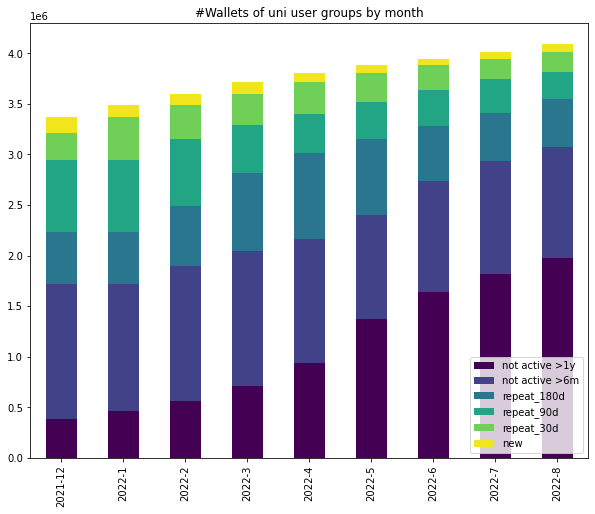

In [68]:
fig, axs=mp.subplots()

kpi_col='num_wallets'

lst_user_grp = ['not active >1y','not active >6m', 'repeat_180d', 'repeat_90d', 'repeat_30d', 'new']

dct_data = {}
for user_grp_name in lst_user_grp:
    dct_data[user_grp_name]=[]
    for m in lst_months:
        if len(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)])>0:
            dct_data[user_grp_name].append(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)][kpi_col].iloc[0])
        else:
            dct_data[user_grp_name].append(0)
    
    

df=pd.DataFrame(dct_data,index=lst_months_labels)
df.plot(kind="bar",stacked=True,figsize=(10,8), color=mp.cm.viridis(50*np.arange(len(lst_user_grp))), ax=axs)
mp.xticks(rotation=90)
mp.title('#Wallets of ' + project + ' user groups by month')
# fig.savefig('charts/user_grp_num_wallets.png')


Text(0.5, 1.0, '%Wallets of 1inch user groups by month')

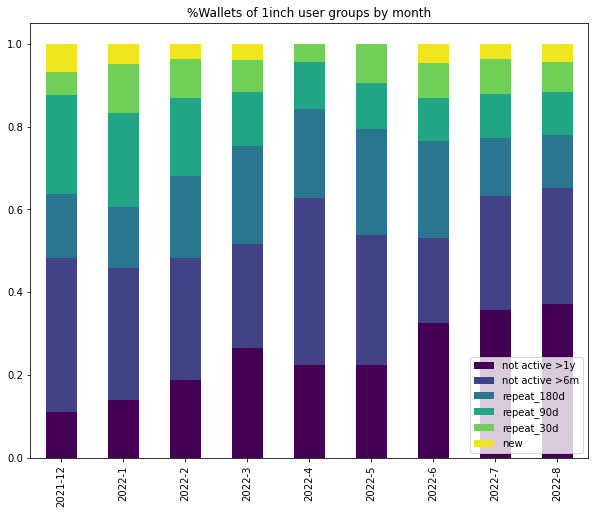

In [40]:
fig, axs=mp.subplots()

kpi_col='share_wallets'

dct_data = {}
for user_grp_name in lst_user_grp:
    dct_data[user_grp_name]=[]
    for m in lst_months:
        if len(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)])>0:
            dct_data[user_grp_name].append(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)][kpi_col].iloc[0])
        else:
            dct_data[user_grp_name].append(0)
    

df=pd.DataFrame(dct_data,index=lst_months_labels)
df.plot(kind="bar",stacked=True,figsize=(10,8), color=mp.cm.viridis(50*np.arange(len(lst_user_grp))), ax=axs)
mp.xticks(rotation=90)
mp.title('%Wallets of 1inch user groups by month')
# fig.savefig('charts/user_grp_share_wallets.png')


Text(0.5, 1.0, 'Share of 30d volume of Cowswap user groups by month')

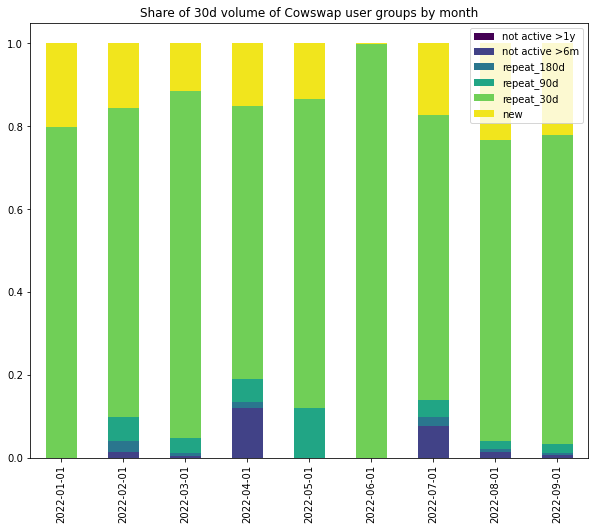

In [17]:
kpi_col='share_vol'

dct_data = {}
for user_grp_name in lst_user_grp:
    dct_data[user_grp_name]=[]
    for m in lst_months:
        if len(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)])>0:
            dct_data[user_grp_name].append(df_grp_month[(df_grp_month.user_grp==user_grp_name) & (df_grp_month.month_date==m)][kpi_col].iloc[0])
        else:
            dct_data[user_grp_name].append(0)
    

df=pd.DataFrame(dct_data,index=lst_months)
df.plot(kind="bar",stacked=True,figsize=(10,8), color=mp.cm.viridis(50*np.arange(len(lst_user_grp))))
mp.xticks(rotation=90)
mp.title('Share of 30d volume of Cowswap user groups by month')

In [41]:
dct_lists_nodes = add_nodes(df_project_monthly,lst_months_labels)
lst_nodes = dct_lists_nodes['lst_nodes']
lst_node_labels = dct_lists_nodes['lst_node_labels']
lst_colors = dct_lists_nodes['lst_colors']

In [42]:
df_sankey = df_sankey_mapping(df_project_monthly)

In [43]:





# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
# data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
# data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
#                                     for src in data['data'][0]['link']['source']]
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = lst_node_labels,
      color = lst_colors
    ),
    link = dict(
      source = df_sankey.source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = df_sankey.target,
      value = df_sankey['num_wallets']
      # label = np.repeat('',len())
      # color=lst_colors
  ))])

fig.update_layout(title_text="#Wallets of 1Inch users by group and month", font_size=10)
fig.show()

# fig.write_html('wallets_sankey.html')

In [44]:


# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
# data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
# data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
#                                     for src in data['data'][0]['link']['source']]
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = lst_node_labels,
      color = lst_colors

    ),
    link = dict(
      source = df_sankey.source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = df_sankey.target,
      value = df_sankey['volume_30d'],
      label = [str(round(df_sankey['volume_30d'].iloc[i]/1000,2)) + 'k' for i in range(0, len(df_sankey))],
      
      # color = ['rgb(' + str(int(mp.cm.viridis(np.arange(x*len(lst_node_labels)))[i][0]*255))+','+ str(int(mp.cm.viridis(np.arange(x*len(lst_node_labels)))[i][1]*255))+','+ str(int(mp.cm.viridis(x*np.arange(len(lst_node_labels)))[i][2]*255)) + ',' + str(opacity) + ')' for i in range(0,len(lst_node_labels))]
  ))])

fig.update_layout(title_text='30d trading volume of ' + project +  ' users by group and month', font_size=10)
fig.show()
# fig.write_html('volume_sankey.html')

In [69]:
# df_project_users = df_project_monthly
df_cohort = make_df_cohort(df_project_monthly[df_project_monthly.month_date==lst_months[-1]],shift_days=0)

In [72]:
df_project_monthly['traded']=0
df_project_monthly.loc[df_project_monthly.volume_30d>0,'traded']=1
# min(df_cohort.cohort)
df_project_monthly_cohort = df_project_monthly.merge(df_cohort[df_cohort.cohort>=0][['trader','cohort']], how='inner', left_on='trader', right_on='trader').reset_index()


In [73]:
# export dataframe
# df_project_monthly_cohort.to_pickle('monthly_cohort'+project+'.pkl')

In [74]:
df_project_cohort = df_project_monthly_cohort.groupby(['cohort','month_date']).agg(num_wallets=('traded','sum'),
volume_30d = ('volume_30d','sum'),
swaps_30d = ('swaps_30d','sum')
).reset_index()

In [75]:
df_project_cohort_all = df_project_monthly_cohort.groupby(['cohort']).agg(num_wallets=('trader','nunique')
).reset_index()


In [76]:
val_col = 'num_wallets'
cohort_pivot = df_project_cohort[['cohort','month_date',val_col]].pivot_table(index = 'cohort',
                                     columns = 'month_date',
                                     values = val_col)

In [77]:
cohort_pivot

month_date,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01
cohort,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80740.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68154.0,18187.0
2,NaN,NaN,NaN,NaN,NaN,NaN,53221.0,15381.0,8285.0
3,NaN,NaN,NaN,NaN,NaN,67366.0,17535.0,8358.0,7241.0
4,NaN,NaN,NaN,NaN,82016.0,22463.0,9329.0,7428.0,7067.0
5,NaN,NaN,NaN,98353.0,36534.0,13257.0,8553.0,7096.0,7118.0
6,NaN,NaN,101521.0,35618.0,16131.0,10816.0,7237.0,6107.0,6260.0
7,NaN,105449.0,39817.0,16661.0,13626.0,9781.0,6396.0,5383.0,5394.0
8,142882.0,43685.0,20136.0,16085.0,13367.0,10291.0,7161.0,6351.0,6353.0


In [78]:
cohort_size=df_project_cohort_all.iloc[:,1]
cohort_size[:9] = [cohort_pivot.iloc[i,8-i] for i in range(0,9)]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0) 


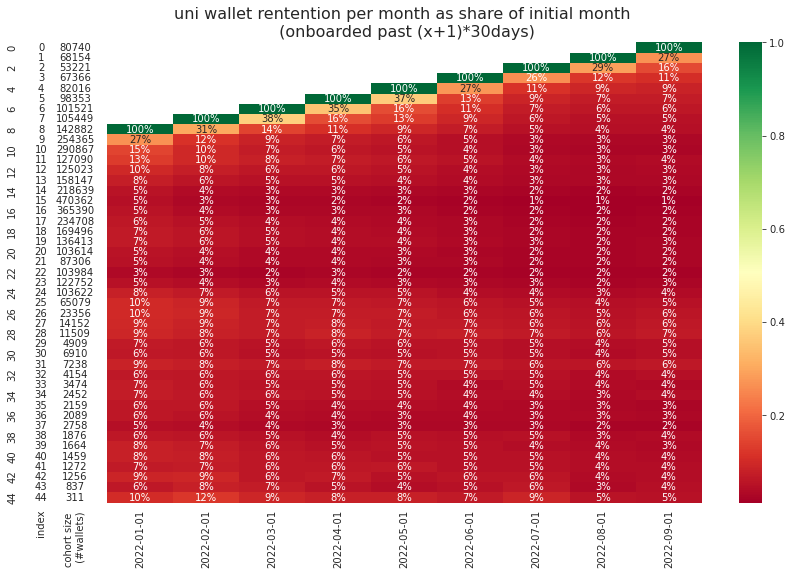

In [79]:


with sns.axes_style("white"):
    fig, ax = mp.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1],yticklabels=False)
    if project =='zerox':
                    project_str='0x'
    else:
                    project_str=project
    ax[1].set_title(project_str + ' wallet rentention per month as share of initial month \n (onboarded past (x+1)*30days)', fontsize=16)
    ax[1].set(xlabel='',
              ylabel='')

    
    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).reset_index()
    cohort_size_df=cohort_size_df.rename(columns={cohort_size_df.columns[1]: 'cohort size \n (#wallets)'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
    # ax[0].set(xlabel='cohort size')
    

    fig.tight_layout()
    fig.savefig('charts/retention_wallets'+project+'.png')

In [80]:
# put horizontal rows from above into one chart such that they all start with 100% at the same time (so x-axis is 'month lifetime')
df_retention_matrix=pd.DataFrame(retention_matrix).reset_index()
df_retention_matrix
retention_matrix_nulled = [list(df_retention_matrix.iloc[i,9-i:])  for i in range(0,9)]

In [81]:
dct_retention={}

for i in range(0,8):
    for j in range(0,8-i):
        retention_matrix_nulled[i].append(np.nan)
    dct_retention[i]=retention_matrix_nulled[i]    

for i in range(8,18):
    dct_retention[i]=df_retention_matrix.iloc[i,1:]
# i=2
# [df_retention_matrix.iloc[9-i:,i]].extend(np.repeat(np.nan(),3))

df_retention_matrix_nulled = pd.DataFrame(dct_retention).reset_index()
df_retention_matrix_nulled

,month_date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2022-01-01,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.265583,0.146871,0.130994,0.097774,0.076005,0.052374,0.046341,0.054301,0.062997
1,2022-02-01,NaN,0.266852,0.289002,0.260295,0.273886,0.371458,0.350844,0.377595,0.305742,0.116404,0.096381,0.095814,0.076842,0.056726,0.038058,0.031246,0.038816,0.049547
2,2022-03-01,NaN,NaN,0.155672,0.124069,0.113746,0.134790,0.158893,0.158001,0.140927,0.085743,0.073755,0.079322,0.062868,0.050371,0.033338,0.026044,0.031878,0.040156
3,2022-04-01,NaN,NaN,NaN,0.107487,0.090568,0.086962,0.106540,0.129219,0.112575,0.072345,0.063008,0.073129,0.060677,0.049024,0.033169,0.024906,0.030649,0.038022
4,2022-05-01,NaN,NaN,NaN,NaN,0.086166,0.072148,0.071286,0.092756,0.093553,0.062603,0.054093,0.064710,0.054382,0.044187,0.029839,0.022481,0.028646,0.036019
5,2022-06-01,NaN,NaN,NaN,NaN,NaN,0.072372,0.060155,0.060655,0.072024,0.047070,0.044677,0.052490,0.042520,0.038926,0.026610,0.019895,0.023260,0.028785
6,2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,0.061662,0.051048,0.050118,0.032654,0.029900,0.039940,0.034234,0.030674,0.021446,0.014510,0.017414,0.021874
7,2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051153,0.044449,0.029175,0.026586,0.034849,0.030474,0.028676,0.020120,0.013158,0.015895,0.019863
8,2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044463,0.028707,0.027380,0.037422,0.032730,0.030067,0.021981,0.013981,0.017559,0.022202


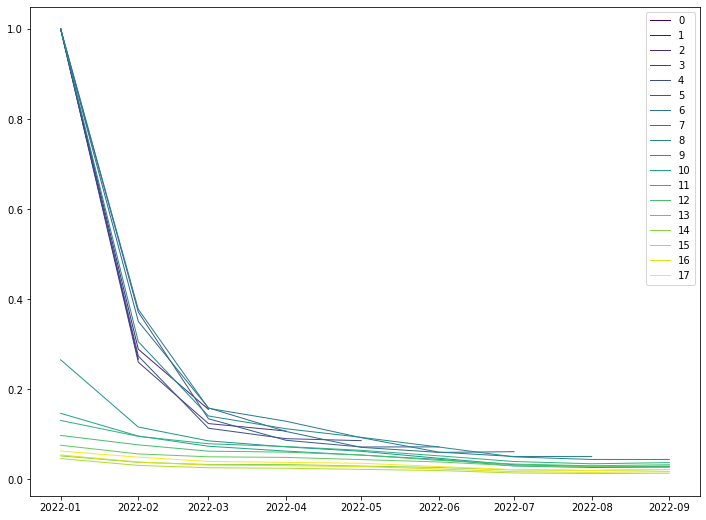

In [82]:
mp.subplots(figsize=(12,9))
num_lines = len(df_retention_matrix_nulled.iloc[:,1:].keys())
colors = mp.cm.viridis(np.linspace(0,1,num_lines))
for i in range(0,num_lines):
    mp.plot(df_retention_matrix_nulled.month_date, df_retention_matrix_nulled.iloc[:,i+1], linewidth=1, color=colors[i], label=str(i))

mp.legend()

In [83]:
#retenteion matrix, but now columns add to 100% of monthly volume
val_col = 'volume_30d'
cohort_pivot = df_project_cohort[['cohort','month_date',val_col]].pivot_table(index = 'cohort',
                                     columns = 'month_date',
                                     values = val_col)
#if totals are columns
cohort_size = [np.nansum(cohort_pivot.iloc[:,i]) for i in range(0, len(cohort_pivot.keys()))]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 1) #change to 0 for users





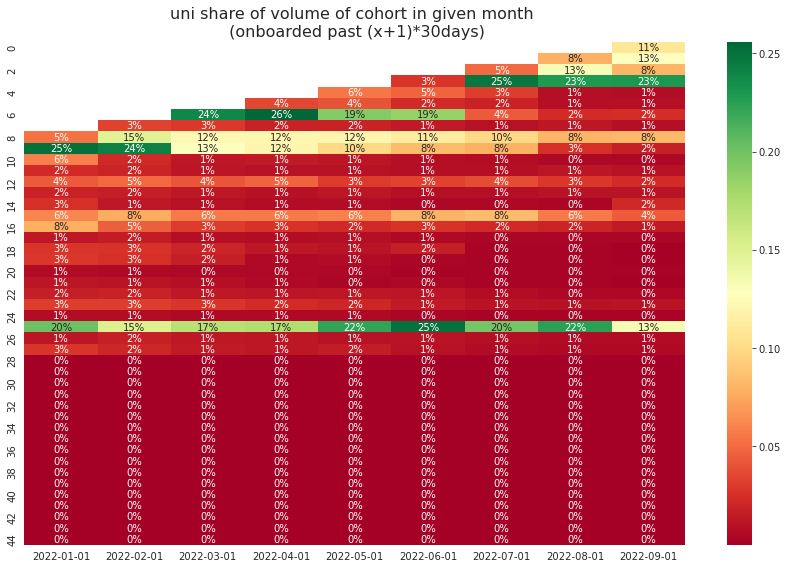

In [84]:
import matplotlib.colors as mcolors
with sns.axes_style("white"):
    fig, axs = mp.subplots(figsize=(12, 8))
    # , gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=axs)
    axs.set_title(project_str + ' share of volume of cohort in given month \n (onboarded past (x+1)*30days)', fontsize=16)
    axs.set(xlabel='',
              ylabel='')

    # # cohort size
    # cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    # white_cmap = mcolors.ListedColormap(['white'])
    # sns.heatmap(cohort_size_df, 
    #             annot=True, 
    #             cbar=False, 
    #             fmt='g', 
    #             cmap=white_cmap, 
    #             ax=ax[0])
    # # ax[0].set(xlabel='#wallets live')

    fig.tight_layout()
    fig.savefig('charts/retention_volume'+project+'.png')